Nadi Astrology Alignment with Machine Learning Simulation

Partha Pratim Ray, 4 June, 2025

parthapratimray1986@gmail.com

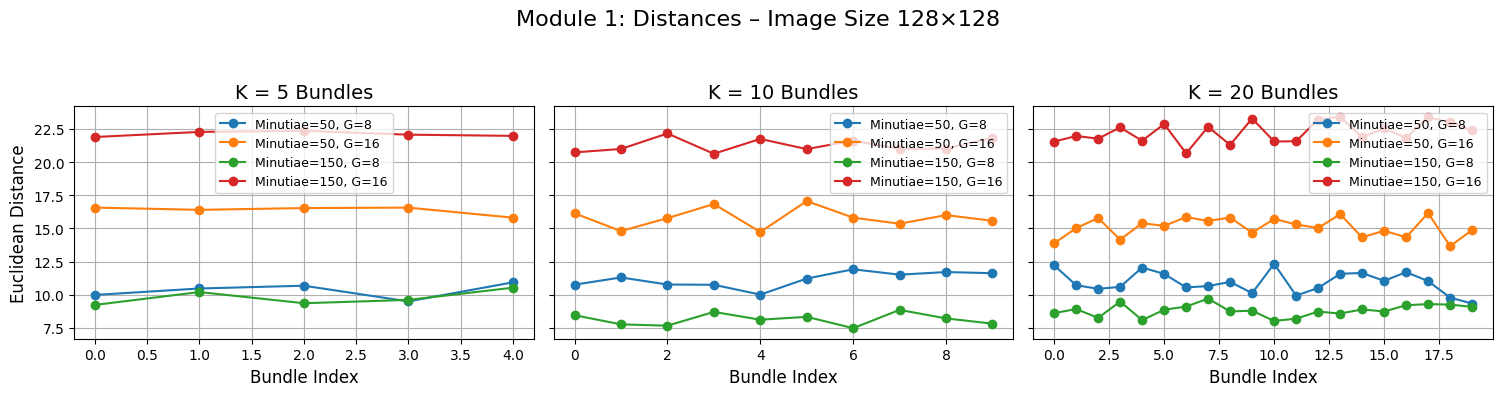

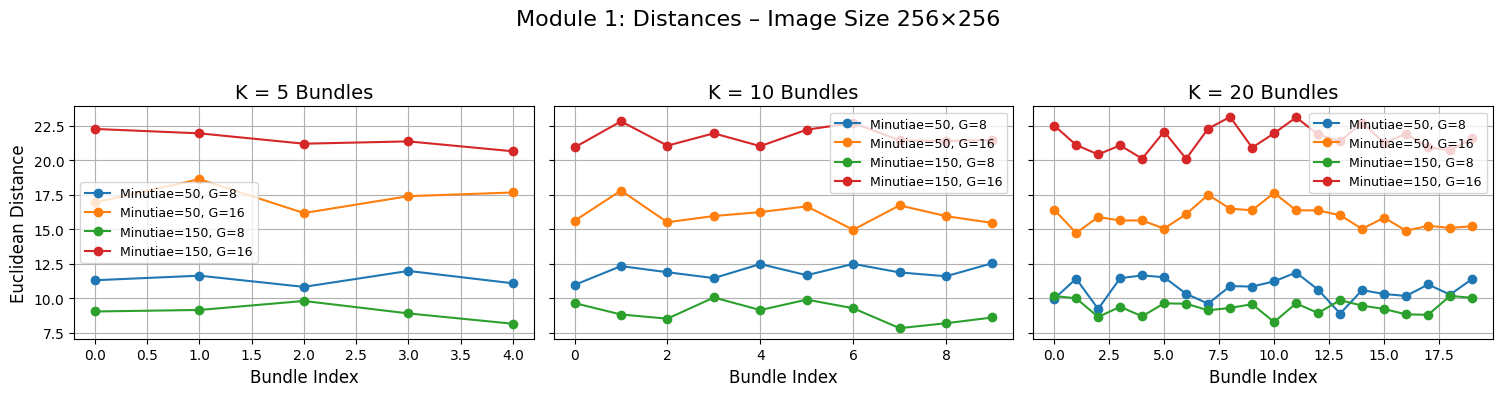

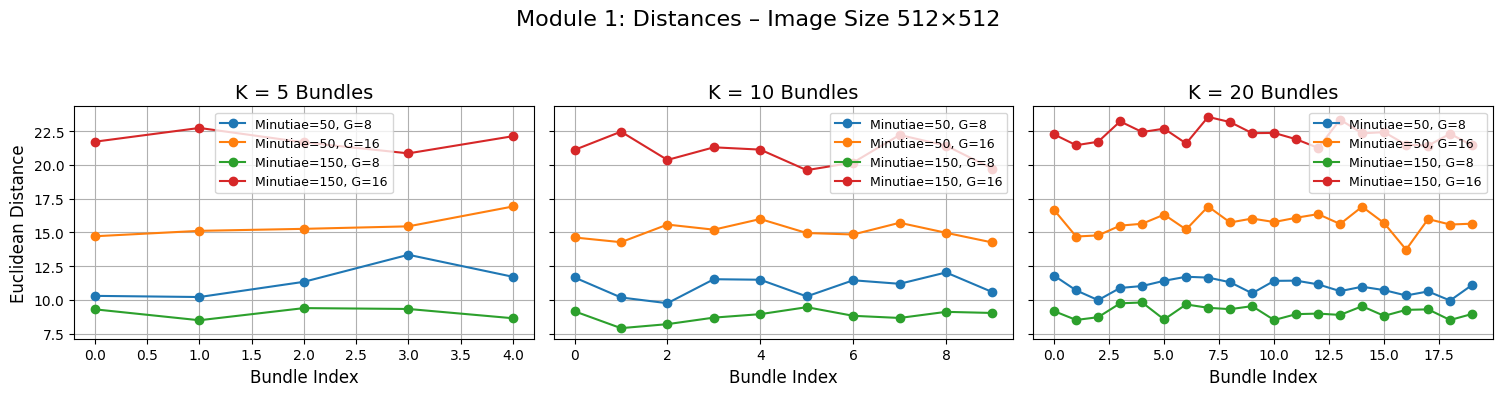

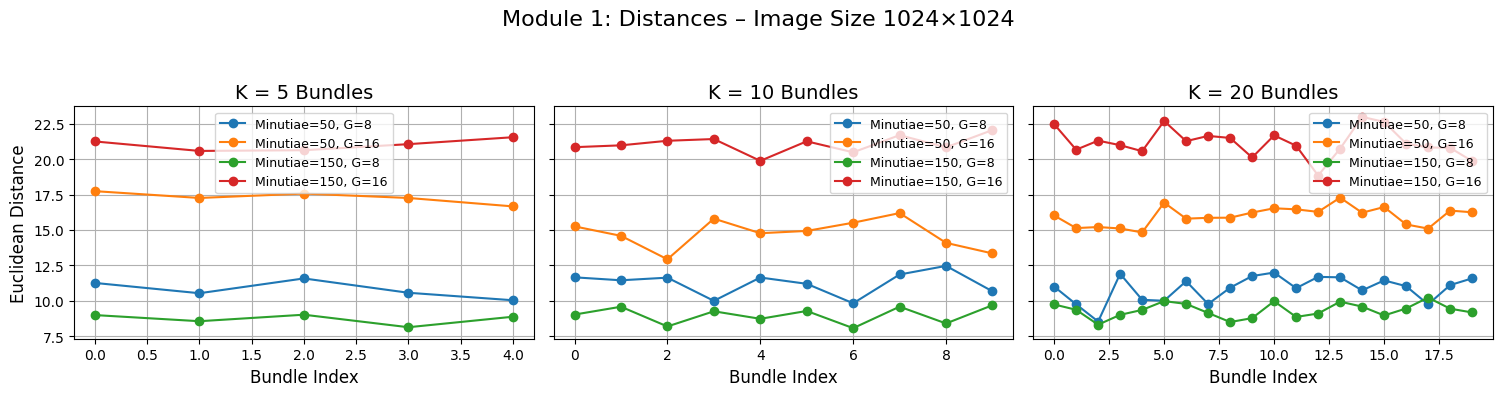

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Set random seed for reproducibility
np.random.seed(42)

# -----------------------------------------
# Helper functions for Module 1
# -----------------------------------------

def simulate_minutiae(num_minutiae, img_shape=(256, 256)):
    """
    Simulate random minutiae for a thumb impression:
    Returns an array of shape (num_minutiae, 3) with (x, y, theta).
    """
    H, W = img_shape
    xs = np.random.randint(0, H, size=num_minutiae)
    ys = np.random.randint(0, W, size=num_minutiae)
    thetas = np.random.uniform(0, np.pi, size=num_minutiae)
    return np.vstack((xs, ys, thetas)).T

def build_grid_embedding(minutiae, img_shape=(256, 256), G=8):
    """
    Build a grid-based embedding from minutiae.
    minutiae: array of shape (n, 3) with (x, y, theta).
    G: number of grid cells per dimension.
    Returns a vector of length 2*G*G (normalized counts + avg. orientations).
    """
    H, W = img_shape
    cell_h = H // G
    cell_w = W // G
    h_counts = []
    orientations = []

    for i in range(G):
        for j in range(G):
            x_min, x_max = i * cell_h, (i + 1) * cell_h
            y_min, y_max = j * cell_w, (j + 1) * cell_w
            mask = (
                (minutiae[:, 0] >= x_min) & (minutiae[:, 0] < x_max) &
                (minutiae[:, 1] >= y_min) & (minutiae[:, 1] < y_max)
            )
            cell_minutiae = minutiae[mask]
            count = len(cell_minutiae)
            h_counts.append(count)
            if count > 0:
                sin_sum = np.sum(np.sin(cell_minutiae[:, 2]))
                cos_sum = np.sum(np.cos(cell_minutiae[:, 2]))
                orientations.append(np.arctan2(sin_sum, cos_sum))
            else:
                orientations.append(0.0)

    h_counts = np.array(h_counts, dtype=float)
    if h_counts.sum() > 0:
        h_norm = h_counts / h_counts.sum()
    else:
        h_norm = h_counts
    embedding = np.hstack([h_norm, np.array(orientations)])
    return embedding

def simulate_distances(K, count, G, img_shape):
    """
    For given K, minutiae count, grid size G, and image size,
    simulate K bundle embeddings, compute centroids, then simulate a new
    embedding and return its distances to each centroid.
    """
    # 1) Simulate K bundle embeddings
    bundle_embeddings = []
    for _ in range(K):
        minutiae = simulate_minutiae(num_minutiae=count, img_shape=img_shape)
        embed = build_grid_embedding(minutiae, img_shape=img_shape, G=G)
        bundle_embeddings.append(embed)
    bundle_embeddings = np.array(bundle_embeddings)

    # 2) Fit KMeans to get centroids
    kmeans = KMeans(n_clusters=K, random_state=42).fit(bundle_embeddings)
    centroids = kmeans.cluster_centers_

    # 3) Simulate new embedding
    new_minutiae = simulate_minutiae(num_minutiae=count, img_shape=img_shape)
    new_embedding = build_grid_embedding(new_minutiae, img_shape=img_shape, G=G)

    # 4) Compute Euclidean distances to centroids
    distances = np.linalg.norm(centroids - new_embedding, axis=1)
    return distances

# -----------------------------------------
# Parameter grids for Module 1
# -----------------------------------------

Ks = [5, 10, 20]
G_values = [8, 16]
minutiae_counts = [50, 150]
img_shapes = [(128, 128), (256, 256), (512, 512), (1024, 1024)]  # extended list

# -----------------------------------------
# Run simulations and plot
# -----------------------------------------

for img_shape in img_shapes:
    fig, axes = plt.subplots(1, len(Ks), figsize=(5 * len(Ks), 4), sharey=True)
    fig.suptitle(
        f"Module 1: Distances – Image Size {img_shape[0]}×{img_shape[1]}",
        fontsize=16
    )

    for idx, K in enumerate(Ks):
        ax = axes[idx]
        for count in minutiae_counts:
            for G in G_values:
                dists = simulate_distances(K=K, count=count, G=G, img_shape=img_shape)
                label = f"Minutiae={count}, G={G}"
                ax.plot(
                    range(K),
                    dists,
                    marker='o',
                    label=label
                )

        ax.set_title(f"K = {K} Bundles", fontsize=14)
        ax.set_xlabel("Bundle Index", fontsize=12)
        if idx == 0:
            ax.set_ylabel("Euclidean Distance", fontsize=12)
        ax.grid(True)
        ax.legend(fontsize=9)

    plt.tight_layout(rect=[0, 0, 1, 0.92])
    plt.show()


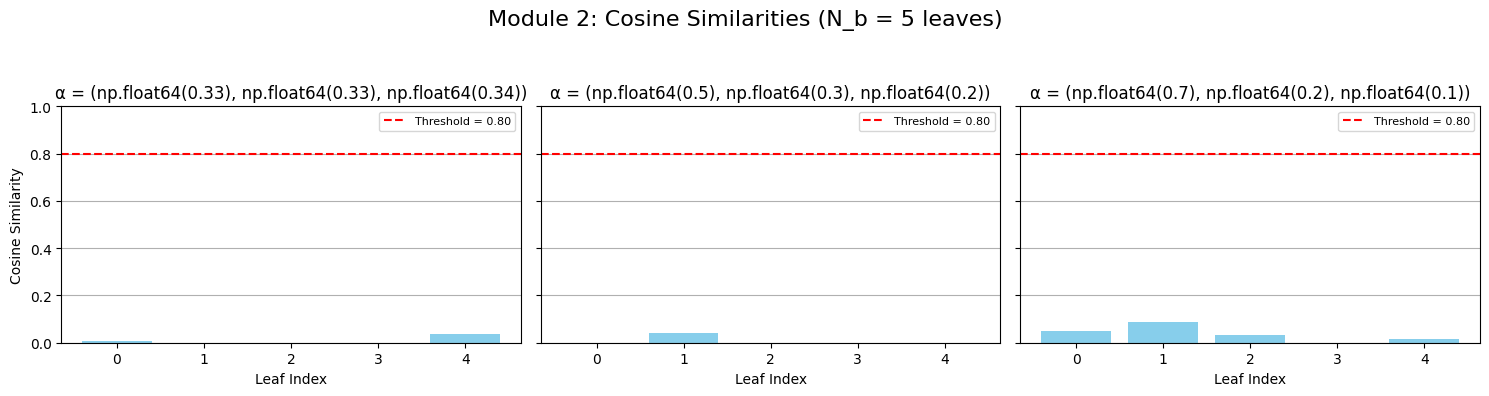

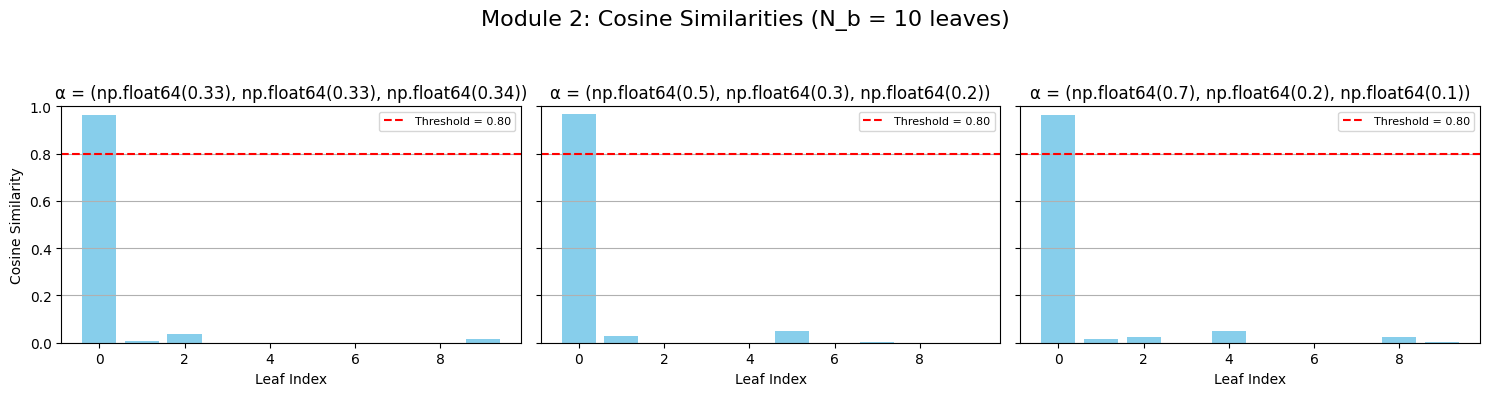

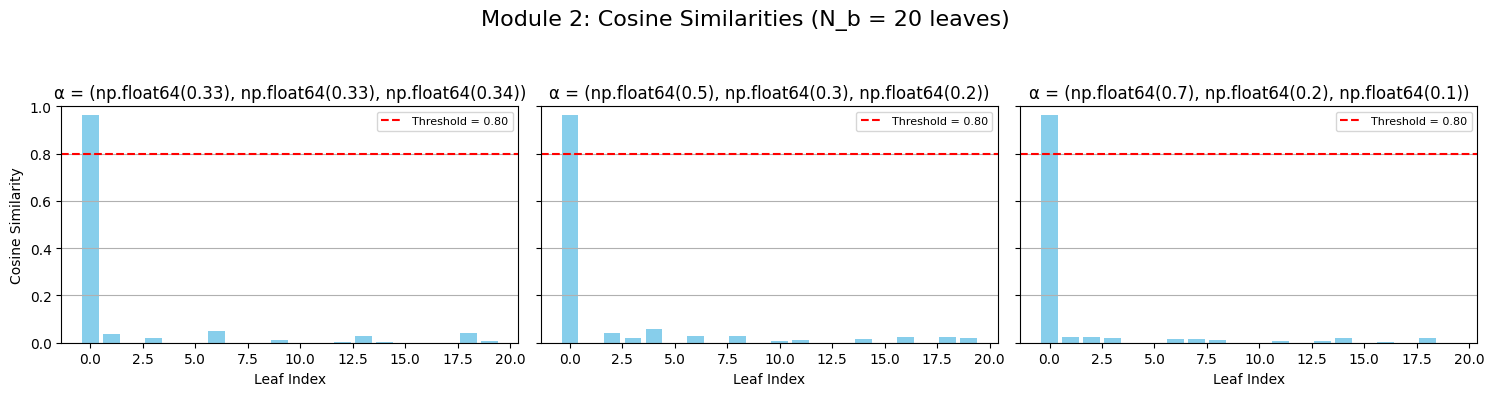

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity

# Fix random seed for reproducibility
np.random.seed(42)

# -----------------------------------------
# Helper functions for Module 2
# -----------------------------------------

def simulate_leaf_embeddings(N_b, dim=768):
    """
    Simulate N_b leaf embeddings of dimension dim, normalized.
    """
    emb = np.random.normal(size=(N_b, dim))
    return normalize(emb, axis=1)

def simulate_attribute_embeddings(num_attrs=3, dim=768):
    """
    Simulate embeddings for `num_attrs` attributes, each of dimension `dim`, normalized.
    """
    attr_embeds = np.random.normal(size=(num_attrs, dim))
    return normalize(attr_embeds, axis=1)

def compute_query_embedding(attr_embeds, alpha):
    """
    Compute a weighted sum of attribute embeddings and normalize.
    `alpha` is a weight array of length equal to number of attributes, summing to 1.
    """
    q = alpha.dot(attr_embeds)
    return q / np.linalg.norm(q)

# -----------------------------------------
# Simulation parameters for Module 2
# -----------------------------------------

leaf_counts = [5, 10, 20]  # number of leaves in a bundle
alpha_sets = [
    np.array([0.33, 0.33, 0.34]),
    np.array([0.5, 0.3, 0.2]),
    np.array([0.7, 0.2, 0.1])  #,  np.array([0.8, 0.1, 0.1])

]
num_attrs = 3
dim = 768
threshold = 0.80

# -----------------------------------------
# Run simulations and plot, injecting a “high‐similarity” leaf whenever N_b is even
# -----------------------------------------

for N_b in leaf_counts:
    # Simulate leaf embeddings (randomly) once per N_b
    leaf_embeddings = simulate_leaf_embeddings(N_b, dim=dim)

    fig, axes = plt.subplots(1, len(alpha_sets), figsize=(5 * len(alpha_sets), 4), sharey=True)
    fig.suptitle(f"Module 2: Cosine Similarities (N_b = {N_b} leaves)", fontsize=16)

    for idx, alpha in enumerate(alpha_sets):
        ax = axes[idx]

        # Simulate attribute embeddings anew for each alpha
        attr_embeds = simulate_attribute_embeddings(num_attrs=num_attrs, dim=dim)
        query_embed = compute_query_embedding(attr_embeds, alpha)

        # Inject one “high‐similarity” leaf if N_b is even
        if N_b % 2 == 0:
            # Make leaf index 0 very close to the query
            noise = 0.01 * np.random.normal(size=(dim,))
            leaf_embeddings[0] = query_embed + noise
            leaf_embeddings = normalize(leaf_embeddings, axis=1)

        # Compute cosine similarities
        sims = cosine_similarity(query_embed.reshape(1, -1), leaf_embeddings).flatten()

        # Plot bar chart
        ax.bar(range(N_b), sims, color='skyblue')
        ax.axhline(threshold, color='r', linestyle='--', label=f"Threshold = {threshold:.2f}")

        # Titles and labels
        ax.set_title(f"α = {tuple(alpha)}", fontsize=12)
        ax.set_xlabel("Leaf Index", fontsize=10)
        if idx == 0:
            ax.set_ylabel("Cosine Similarity", fontsize=10)
        ax.set_ylim(0, 1)
        ax.grid(axis='y')
        ax.legend(fontsize=8)

    plt.tight_layout(rect=[0, 0, 1, 0.92])
    plt.show()


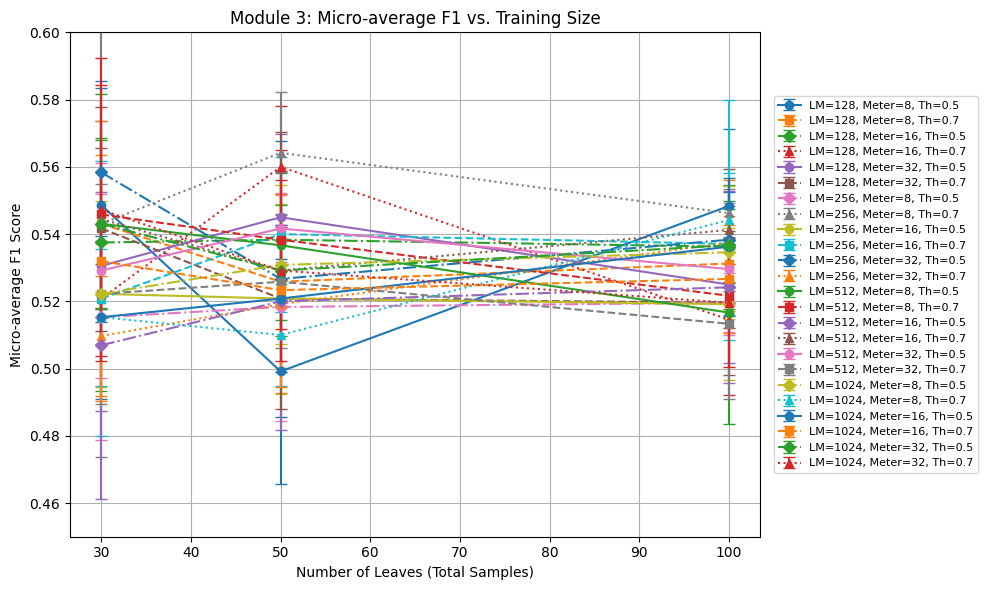

,LM_dim,Meter_dim,Train_Size,Threshold,Mean_F1,Std_F1
0,128,8,30,0.5,0.548611,0.034861
1,128,8,30,0.7,0.543056,0.020318
2,128,8,50,0.5,0.499167,0.033479
3,128,8,50,0.7,0.525833,0.033061
4,128,8,100,0.5,0.548333,0.022913
...,...,...,...,...,...,...
67,1024,32,30,0.7,0.547222,0.045091
68,1024,32,50,0.5,0.529167,0.019543
69,1024,32,50,0.7,0.529167,0.026874
70,1024,32,100,0.5,0.536667,0.010913


In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import pandas as pd

# Fix random seed for reproducibility
np.random.seed(42)

# -----------------------------------------
# Helper functions for Module 3
# -----------------------------------------

def simulate_leaf_features_and_labels(num_leaves, LM_dim=512, meter_dim=32, num_kandams=16):
    """
    Simulate features (concatenated LM and meter embeddings) and multi-label ground truth.
    Ensures Kaṇḍam 1 is always present.
    """
    LM_embeds = np.random.normal(size=(num_leaves, LM_dim))
    Meter_embeds = np.random.normal(size=(num_leaves, meter_dim))
    features = np.hstack([LM_embeds, Meter_embeds])
    labels = np.random.randint(0, 2, size=(num_leaves, num_kandams))
    labels[:, 0] = 1  # Kaṇḍam 1 always present
    return features, labels

def train_and_evaluate_model(features, labels, threshold=0.5, test_size=0.3, random_state=None):
    """
    Train one logistic regression classifier per Kaṇḍam and compute micro-average F1 score.
    Predictions are thresholded at `threshold`.
    """
    X_train, X_test, y_train, y_test = train_test_split(
        features, labels, test_size=test_size, random_state=random_state
    )
    num_kandams = labels.shape[1]
    y_pred_proba = np.zeros_like(y_test, dtype=float)
    y_pred = np.zeros_like(y_test, dtype=int)

    # Train logistic regression for each Kaṇḍam
    for k in range(num_kandams):
        # If all training labels are the same, skip training and predict that constant
        if len(np.unique(y_train[:, k])) < 2:
            y_pred[:, k] = y_train[0, k]
        else:
            clf = LogisticRegression(max_iter=500)
            clf.fit(X_train, y_train[:, k])
            y_pred_proba[:, k] = clf.predict_proba(X_test)[:, 1]
            y_pred[:, k] = (y_pred_proba[:, k] >= threshold).astype(int)

    f1 = f1_score(y_test.flatten(), y_pred.flatten(), average='micro')
    return f1

# -----------------------------------------
# Parameters to vary
# -----------------------------------------

training_sizes = [30, 50, 100]      # total number of leaves
LM_dims = [128, 256, 512, 1024]               # dimension of LM embedding
meter_dims = [8, 16, 32]              # dimension of meter embedding
thresholds = [0.5, 0.7]            # decision thresholds for sigmoid output
num_trials = 5                     # number of trials for each setting
num_kandams = 16                   # number of Kaṇḍams (multi-label)

# -----------------------------------------
# Run simulations
# -----------------------------------------

results = []

for LM_dim in LM_dims:
    for meter_dim in meter_dims:
        for size in training_sizes:
            for thresh in thresholds:
                f1_scores = []
                for trial in range(num_trials):
                    features, labels = simulate_leaf_features_and_labels(
                        num_leaves=size,
                        LM_dim=LM_dim,
                        meter_dim=meter_dim,
                        num_kandams=num_kandams
                    )
                    f1 = train_and_evaluate_model(
                        features,
                        labels,
                        threshold=thresh,
                        test_size=0.3,
                        random_state=trial
                    )
                    f1_scores.append(f1)

                results.append({
                    'LM_dim': LM_dim,
                    'Meter_dim': meter_dim,
                    'Train_Size': size,
                    'Threshold': thresh,
                    'Mean_F1': np.mean(f1_scores),
                    'Std_F1': np.std(f1_scores)
                })

# Convert results to DataFrame
df_results = pd.DataFrame(results)

# -----------------------------------------
# Plotting F1 vs. Training Size for each configuration
# -----------------------------------------

plt.figure(figsize=(10, 6))
markers = ['o', 's', 'D', '^']
linestyles = ['-', '--', '-.', ':']
idx = 0

for LM_dim in LM_dims:
    for meter_dim in meter_dims:
        for thresh in thresholds:
            subset = df_results[
                (df_results['LM_dim'] == LM_dim) &
                (df_results['Meter_dim'] == meter_dim) &
                (df_results['Threshold'] == thresh)
            ]
            # Sort by Train_Size
            subset = subset.sort_values('Train_Size')
            plt.errorbar(
                subset['Train_Size'],
                subset['Mean_F1'],
                yerr=subset['Std_F1'],
                marker=markers[idx % len(markers)],
                linestyle=linestyles[idx % len(linestyles)],
                capsize=4,
                label=f"LM={LM_dim}, Meter={meter_dim}, Th={thresh}"
            )
            idx += 1

plt.title("Module 3: Micro-average F1 vs. Training Size")
plt.xlabel("Number of Leaves (Total Samples)")
plt.ylabel("Micro-average F1 Score")
plt.ylim(0.45, 0.6)
plt.legend(
    fontsize=8,
    loc='center left',
    bbox_to_anchor=(1.02, 0.5),
    borderaxespad=0
)
plt.grid(True)
plt.tight_layout()
plt.show()

# Display the DataFrame of results
display(df_results)


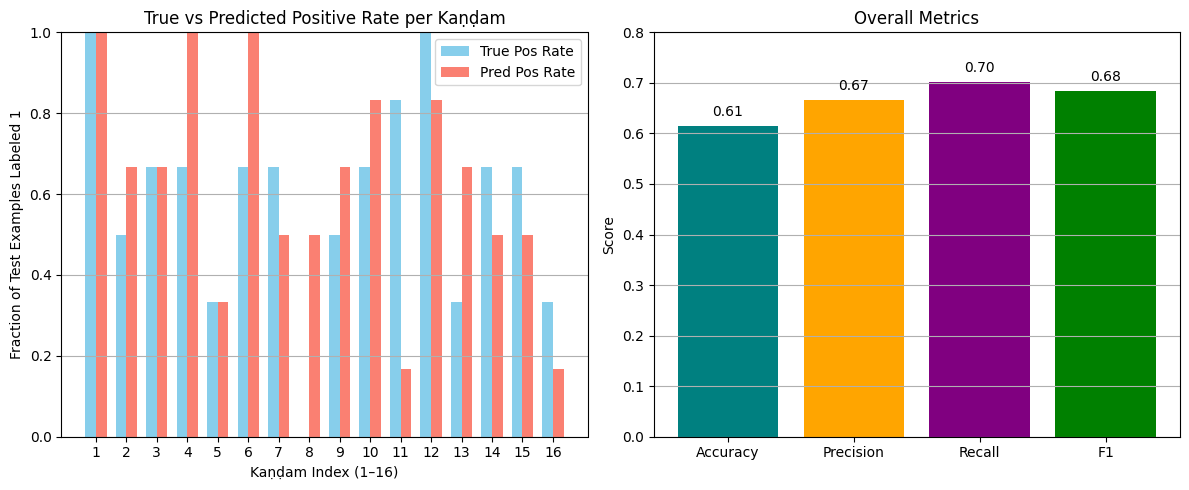

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

# Fix random seed for reproducibility
np.random.seed(0)

# -----------------------------------------
# Helper functions for a single trial of Module 3
# -----------------------------------------

def simulate_leaf_features_and_labels(num_leaves, LM_dim=64, meter_dim=16, num_kandams=16):
    """
    Simulate features (concatenated LM and meter embeddings) and multi-label ground truth.
    Ensures Kaṇḍam 1 is always present.
    """
    LM_embeds = np.random.normal(size=(num_leaves, LM_dim))
    Meter_embeds = np.random.normal(size=(num_leaves, meter_dim))
    features = np.hstack([LM_embeds, Meter_embeds])
    labels = np.random.randint(0, 2, size=(num_leaves, num_kandams))
    labels[:, 0] = 1  # Kaṇḍam 1 always present
    return features, labels

def train_and_predict(features, labels, threshold=0.5, test_size=0.3, random_state=0):
    """
    Train one logistic regression per Kaṇḍam and return true and predicted labels on the test set.
    """
    X_train, X_test, y_train, y_test = train_test_split(
        features, labels, test_size=test_size, random_state=random_state
    )
    num_kandams = labels.shape[1]
    y_pred = np.zeros_like(y_test, dtype=int)

    for k in range(num_kandams):
        # If training labels for this Kaṇḍam are all identical, predict that constant
        if len(np.unique(y_train[:, k])) < 2:
            y_pred[:, k] = y_train[0, k]
        else:
            clf = LogisticRegression(max_iter=500)
            clf.fit(X_train, y_train[:, k])
            proba = clf.predict_proba(X_test)[:, 1]
            y_pred[:, k] = (proba >= threshold).astype(int)

    return y_test, y_pred

# -----------------------------------------
# Run a single trial and plot results
# -----------------------------------------


######### The “positive rate” (Pos Rate) for a given Kaṇḍam is simply the fraction of test‐set examples whose label for that Kaṇḍam is 1 (“present”).
##### Concretely, if you have N_test test leaves and for Kaṇḍam k exactly M of them have y_k = 1, then

# Simulate data
num_leaves = 20
features, labels = simulate_leaf_features_and_labels(
    num_leaves=num_leaves, LM_dim=64, meter_dim=16, num_kandams=16
)

# Train and get predictions
y_true, y_pred = train_and_predict(features, labels, threshold=0.5, test_size=0.3, random_state=0)

# Compute fraction of positives for each Kaṇḍam (true vs predicted)
num_test = y_true.shape[0]
true_counts = y_true.sum(axis=0) / num_test
pred_counts = y_pred.sum(axis=0) / num_test

# Compute overall metrics
y_true_flat = y_true.flatten()
y_pred_flat = y_pred.flatten()
accuracy = accuracy_score(y_true_flat, y_pred_flat)
precision = precision_score(y_true_flat, y_pred_flat, zero_division=0)
recall = recall_score(y_true_flat, y_pred_flat, zero_division=0)
f1 = f1_score(y_true_flat, y_pred_flat)

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Left: True vs Predicted Positive Rate per Kaṇḍam
k_indices = np.arange(1, 17)
width = 0.35
axes[0].bar(k_indices - width/2, true_counts, width, label='True Pos Rate', color='skyblue')
axes[0].bar(k_indices + width/2, pred_counts, width, label='Pred Pos Rate', color='salmon')
axes[0].set_title("True vs Predicted Positive Rate per Kaṇḍam")
axes[0].set_xlabel("Kaṇḍam Index (1–16)")
axes[0].set_ylabel("Fraction of Test Examples Labeled 1")
axes[0].set_xticks(k_indices)
axes[0].set_ylim(0, 1)
axes[0].legend()
axes[0].grid(axis='y')

# Right: Overall Metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
values = [accuracy, precision, recall, f1]
colors = ['teal', 'orange', 'purple', 'green']
axes[1].bar(metrics, values, color=colors)
axes[1].set_title("Overall Metrics")
axes[1].set_ylim(0, 1)
for i, v in enumerate(values):
    axes[1].text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=10)
axes[1].set_ylabel("Score")
plt.ylim(0, .8)
axes[1].grid(axis='y')

plt.tight_layout()
plt.show()
